# bilibili-recommend with SVD
之前我们对于番剧推荐基于共现矩阵直接计算向量的余弦相似度再加上其他的一些关于声优、番剧名称等得到相似度。现在我们将通过一次SVD来得到，我们先看看SVD的效果如何，后续我们会使用GloVe来进行训练。

In [2]:
import json
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

idChange = json.load(open("D:/ML/animeId.json"))
def changeId(old):
    for i in range(len(idChange)):
        if(idChange[i] == old):
            return i


In [631]:
bilibili = {}
fans = np.zeros(3402)
with open('D:/ML/bilibili.json', 'r',encoding="utf-8") as f:    
    # 逐行读取    
    for line in f:
        bangumi = json.loads(line)
        # 格式化，然后每行作为list的一个元素    
        bilibili[bangumi["animeId"]] = bangumi["animeTitle"]
        try:
            fans[changeId("animeId")] = bangumi["fans"]
        except:
            fans[changeId("animeId")] = 100
co_occurrance = np.zeros((3402, 3402))
# 获得共现矩阵
with open('D:/ML/alluserlocal.json', 'r',encoding="utf-8") as f:    
    # 逐行读取
    count = 0;
    for line in f:
        bangumi = json.loads(line)
        animes = []
        for anime in bangumi["likevideo"]:
            id = changeId(anime)
            if id == None:
                continue
            else:
                animes.append(id)
        size = len(animes)
        for anime in animes:
            for bnime in animes:
                if anime != bnime:
                    try:
                        mul = 1
                        if(bangumi["vip"]["vipStatus"] == 1):
                            mul = 2
                        co_occurrance[anime][bnime] += 1.0*mul/size
                    except IndexError:
                        continue

In [632]:
la = np.linalg
co_occurrance = co_occurrance*np.log(co_occurrance+1)
print(co_occurrance[co_occurrance < 0])
U, s, Vh = la.svd(co_occurrance)
print(s.shape)

[]
(3402,)


In [633]:
dis = 10
fans = fans/(np.max(fans)*10)
U = U[:,:dis]
U = np.c_[U,fans]
# add fans for special
print(U.shape)

(3402, 11)


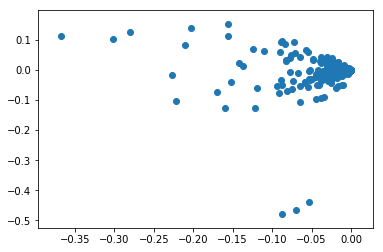

In [634]:
import matplotlib.pyplot as plt
def Id2Name(animeId):
    return bilibili[str(animeId)]
plt.scatter(U[:,0],U[:,1],)

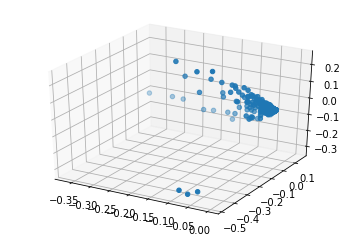

In [635]:
from mpl_toolkits.mplot3d import Axes3D
ax = plt.subplot(111, projection='3d')
ax.scatter(U[:,0],U[:,1],U[:,2])

(array([2.100e+01, 1.000e+00, 1.000e+00, 3.344e+03, 3.000e+00, 1.300e+01,
        1.000e+00, 1.600e+01, 1.000e+00, 1.000e+00]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

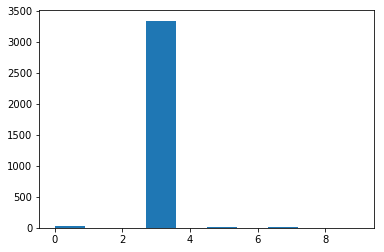

In [636]:
from sklearn.cluster import KMeans
n_clusters = 10
cluster = KMeans(n_clusters)
cluster.fit(U)
plt.hist(cluster.labels_)

In [637]:
clusters = []
for i in range(n_clusters):
    clusters.append(U[np.where(cluster.labels_ == i),][0])
c_map = ["r","g","b","c","m","tan","goldenrod","k","lightseagreen","darkgray"]

(21,)
(1,)
(1,)
(3344,)
(3,)
(13,)
(1,)
(16,)
(1,)
(1,)


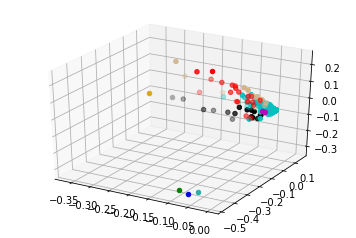

In [638]:
ax_cluster = plt.subplot(111, projection='3d')
for cls,color in zip(clusters,c_map):
    print(cls[:,0].shape)
    ax_cluster.scatter(cls[:,0],cls[:,1],cls[:,2], c=color)

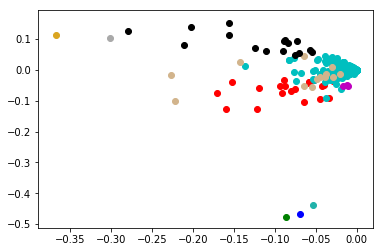

In [639]:
for cls,color in zip(clusters,c_map):
    plt.scatter(cls[:,0],cls[:,1], c=color)

In [640]:
names = []
for i in range(3402):
    if cluster.labels_[i] == 4:
        try:
            names.append(Id2Name(idChange[i]))
        except KeyError:
            continue

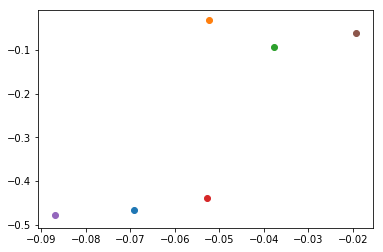

In [674]:
# select fate to see the position
fate = ["2661","645","5997","1547","2747","1293","5800","5798","1057","3048","5027","5793","6440","21557","963","427","177","3756"]
fate = ["1587","5747","1650","2843","1586","779"]# 
ids = []
X = []
Y = []
for anime in fate:
    x = changeId(anime)
    ids.append(x)
    X.append(U[x,0])
    Y.append(U[x,1])
for i in range(len(X)):
    plt.scatter(X[i],Y[i])

In [677]:
from sklearn.cluster import DBSCAN as DB 

def prt(my_favorite):
    #首先对我喜爱的番剧作密度聚类
    vectors = []
    for item in my_favorite:
        vectors.append(U[item])
    db = DB(metric="cosine")
    db.fit(np.array(vectors))
    # split
    up_bound = max(db.labels_)
    if up_bound < 0: 
        up_bound = 1
    clus = []
    index = 0
    for label in db.labels_:
        if(label == -1 and up_bound != 1):
            continue
        clus.append(vectors[index])
        index += 1
    recommend = []
    print(len(clus))
    for c in clus:
        mean = np.zeros(dis+1)
        for it in c:
            mean += it
        mean /= len(c)
        result = cosine_similarity(U,[mean]).reshape(3402)
        result_index = np.argsort(-result)
        for i in range(10):
            if(result_index[i] not in recommend and result_index[i] not in my_favorite):
                recommend.append(result_index[i])
    for item in recommend:
        try:
            print(Id2Name(idChange[item]))
        except KeyError:
            continue
                         

In [678]:
prt(ids)

6
百武装战记
线上游戏的老婆不可能是女生？
学战都市Asterisk 第二季
弹丸论破3 -未来篇-
Taboo Tattoo－禁忌咒纹－
弹丸论破3 -绝望篇-
双星之阴阳师
迷家
热诚传说X
Rewrite
黑子的篮球
黑子的篮球 第2期
黑子的篮球 第3期
OVERLORDⅡ
狐妖小红娘
魔卡少女樱 CLEAR CARD篇
博多豚骨拉面团
Fate/Apocrypha
